In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
from PINN.VanillaOptions import VanillaOptionPINN
from PINN.utilities import xavier_init, V_BS, V_BS_CN, V_quantlib, european_option_greeks

import warnings
warnings.filterwarnings("ignore")

## European Put Option

In [2]:
# parameters
TYPE = 'put'
STYLE = 'european'
K = 100
sigma = 0.3
r = 0.05
T = 1
S_inf = 3 * K

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load results
ARCHITECTURE = 'MLP(10,10,10,10)tanh_sobol'
MODEL_PATH = f'./models/{STYLE}_{TYPE}_{ARCHITECTURE}/'
FILE_NAME = f'{STYLE}_{TYPE}_{ARCHITECTURE}.npy'
results = np.load(f'data/output/{FILE_NAME}', allow_pickle=True).item()
RMSE = results['RMSE']
MPE = results['MPE']  # max pointwise error

idx = [i for i in range(len(RMSE)) if RMSE[i] < 1]
RMSE_mean = RMSE[idx].mean()
RMSE_std = RMSE[idx].std()
RMSE_mean_std = {'mean': RMSE_mean, 'std': RMSE_std}
mpe_mean = MPE[idx].mean()
mpe_std = MPE[idx].std()
best_idx = np.argmin(RMSE)

GREEKS = results['GREEKS']
RMSE_greeks = {}
MPE_greeks = {}
for greek in GREEKS:
    RMSE_greeks[greek] = results[f'RMSE_{greek}']
    MPE_greeks[greek] = results[f'MPE_{greek}']
RMSE_greeks_mean = {greek: RMSE_greeks[greek].mean() for greek in GREEKS}
RMSE_greeks_std = {greek: RMSE_greeks[greek].std() for greek in GREEKS}
mpe_greeks_mean = {greek: MPE_greeks[greek].mean() for greek in GREEKS}
mpe_greeks_std = {greek: MPE_greeks[greek].std() for greek in GREEKS}

SEEDS = results['SEEDS']

model_name = f'{STYLE}_{TYPE}_{best_idx}'
model = torch.load(MODEL_PATH+f'{model_name}.pt', map_location=device)

VanillaOptionPINN(
  (V_nn): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): Tanh()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): Tanh()
    (8): Linear(in_features=10, out_features=1, bias=True)
  )
)
Number of parameters: 371


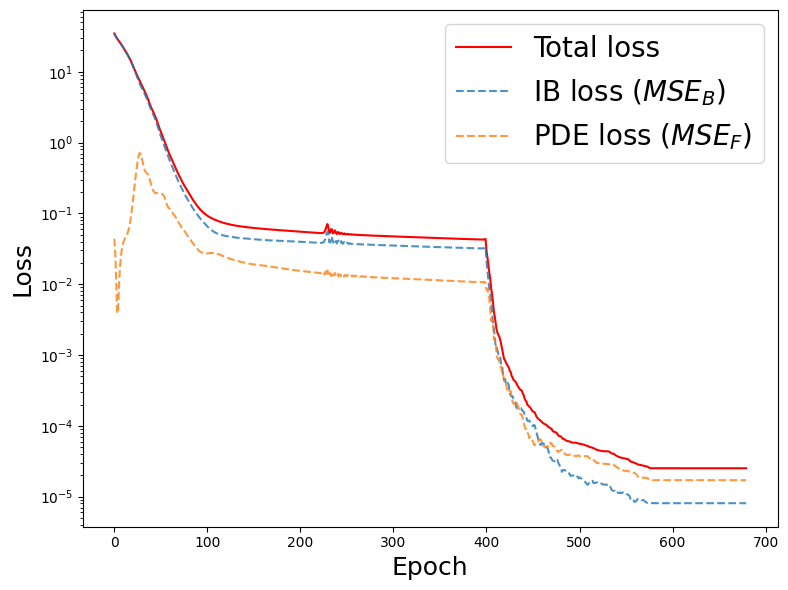

Final loss: 2.5163568352581933e-05


In [76]:
print(model)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))
model.plot_history(save=True, title='', figsize=(8, 6), fontsize=18, file_name=f'data/figures/loss_{FILE_NAME}.pdf')
print('Final loss:', model.loss_history['total'][-1])

### Error Analysis and Comparison with Crank Nicolson

MPE 0.27063965797424316
MPE at: 0.0 102.10210210210211


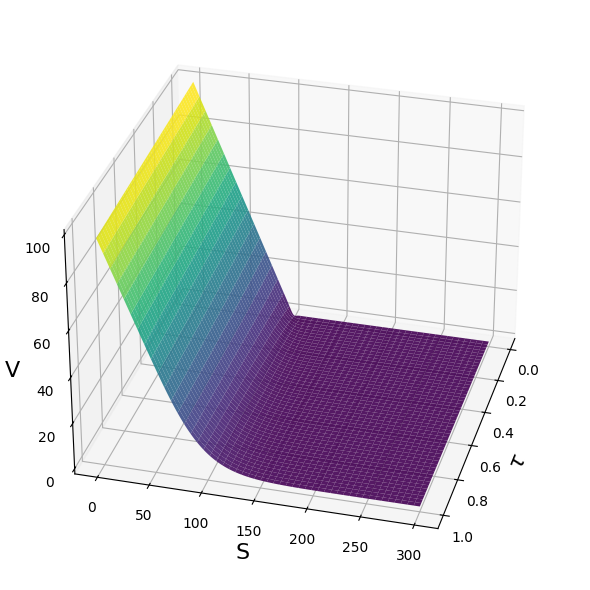

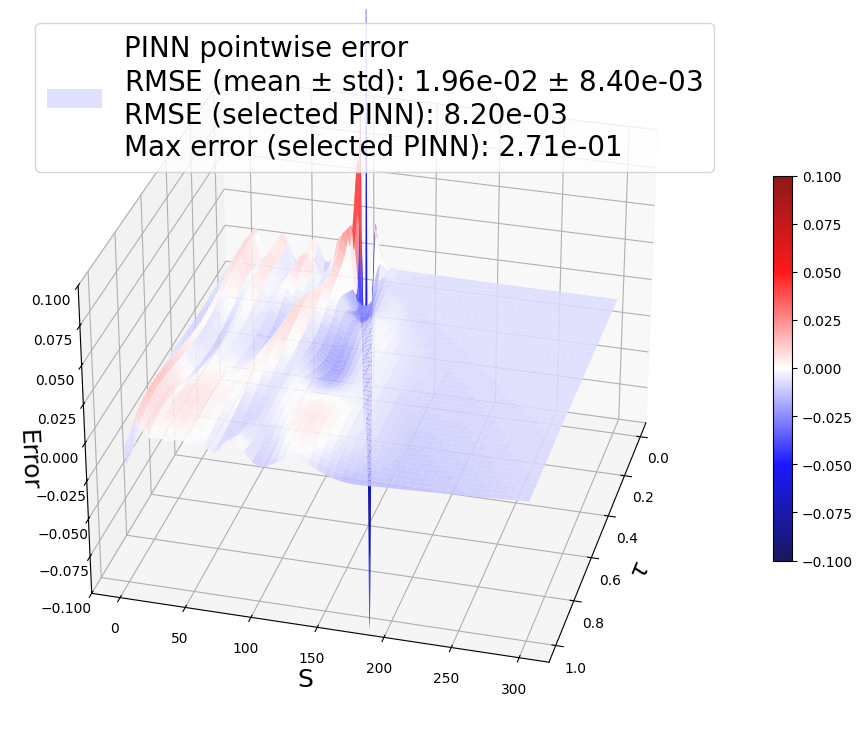

In [77]:
SAVE_FIG = True

S_eval = torch.linspace(0, S_inf, 1000)
tau_eval = torch.linspace(0, T, 1000)
S_eval, tau_eval = torch.meshgrid(S_eval, tau_eval, indexing='xy')
V_pred = model(tau_eval.reshape(-1, 1), S_eval.reshape(-1, 1)).detach().numpy().reshape(1000, 1000)

S_eval = np.linspace(0, S_inf, 1000)
tau_eval = np.linspace(0, T, 1000)
S_eval, tau_eval = np.meshgrid(S_eval, tau_eval)
V_true = V_BS(tau_eval, S_eval, K, sigma, r, 'put')
V_err = V_pred - V_true
mse = np.mean(V_err**2)
rmse = np.sqrt(mse)
mpe = np.max(np.abs(V_err))
print('MPE', mpe)
idx = np.unravel_index(np.argmax(np.abs(V_err)), V_err.shape)
print('MPE at:', tau_eval[idx], S_eval[idx])

# 3d plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, V_pred,
                       cmap='viridis', alpha=0.9)
ax.set_xlabel(r'$\tau$', fontsize=16)
ax.set_ylabel('S', fontsize=16)
ax.set_zlabel('V', fontsize=16)
ax.view_init(elev=30, azim=15)
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(f'./data/figures/sol_{FILE_NAME}.pdf', bbox_inches='tight')
plt.show()

# plot error surface
scale = 0.1
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, V_err,
                       label=f'PINN pointwise error\nRMSE (mean $\pm$ std): {RMSE_mean:.2e} $\pm$ {RMSE_std:.2e}\nRMSE (selected PINN): {rmse:.2e}\nMax error (selected PINN): {mpe:.2e}',
                       cmap='seismic', vmin=-scale, vmax=scale, alpha=0.9)
cbar = fig.colorbar(surf, location='right', shrink=0.5)
ax.set_zlim(-scale, scale)
ax.set_xlabel(r'$\tau$', fontsize=18)
ax.set_ylabel('S', fontsize=18)
ax.set_zlabel('Error', fontsize=18)
# ax.set_zscale('symlog')
plt.legend(fontsize=20, loc='upper right')
ax.view_init(elev=30, azim=15)
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(f'./data/figures/err_{FILE_NAME}.pdf', bbox_inches='tight')
plt.show()

MPE 0.6666664883255778


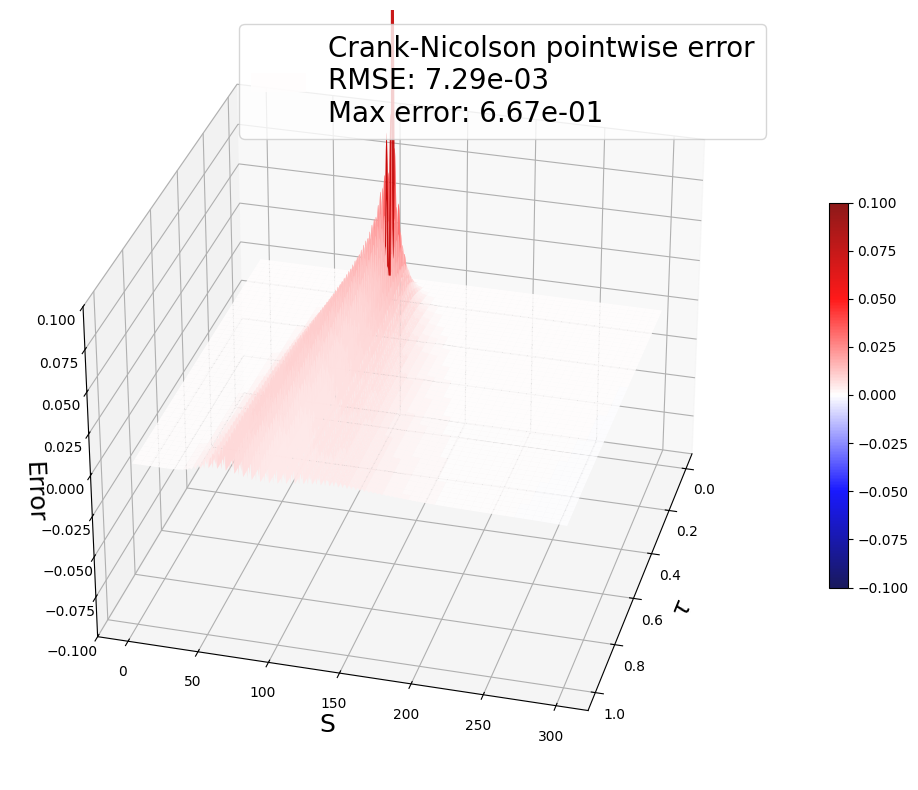

In [78]:
from scipy.interpolate import RegularGridInterpolator

SAVE_FIG = True

# Crank-Nicolson solution
V_CN, t_CN, S_CN = V_BS_CN(100, 100, K, T, sigma, r, S_inf, type='put', style='european')

# interpolate CN solution on eval grid
interpolator = RegularGridInterpolator((t_CN, S_CN), V_CN, method='linear', bounds_error=False, fill_value=np.nan)
S_eval = np.linspace(0, S_inf, 1000)
tau_eval = np.linspace(0, T, 1000)
S_eval, tau_eval = np.meshgrid(S_eval, tau_eval)
V_pred_CN = interpolator((tau_eval, S_eval))

# compute error metrics
V_true = V_BS(tau_eval, S_eval, K, sigma, r)
V_err_CN = V_pred_CN - V_true
MSE_CN = np.mean(V_err_CN**2)
RMSE_CN = np.sqrt(MSE_CN)
MPE_CN = np.max(np.abs(V_err_CN))
print('MPE', MPE_CN)

# plot error surface
scale = 0.1
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, V_err_CN,
                       label=f'Crank-Nicolson pointwise error\nRMSE: {RMSE_CN:.2e}\nMax error: {MPE_CN:.2e}',
                       cmap='seismic', vmin=-scale, vmax=scale, alpha=0.9)
cbar = fig.colorbar(surf, location='right', shrink=0.5)
ax.set_zlim(-scale, scale)
ax.set_xlabel(r'$\tau$', fontsize=18)
ax.set_ylabel('S', fontsize=18)
ax.set_zlabel('Error', fontsize=18)
# ax.set_zscale('symlog')
plt.legend(fontsize=20, loc='upper right')
ax.view_init(elev=30, azim=15)
plt.tight_layout()
if SAVE_FIG:
    plt.savefig('./data/figures/err_european_put_cn.pdf', bbox_inches='tight')
plt.show()

### Greeks

Delta RMSE: 0.0015457041693959315
Delta MPE: 0.0849534077486993


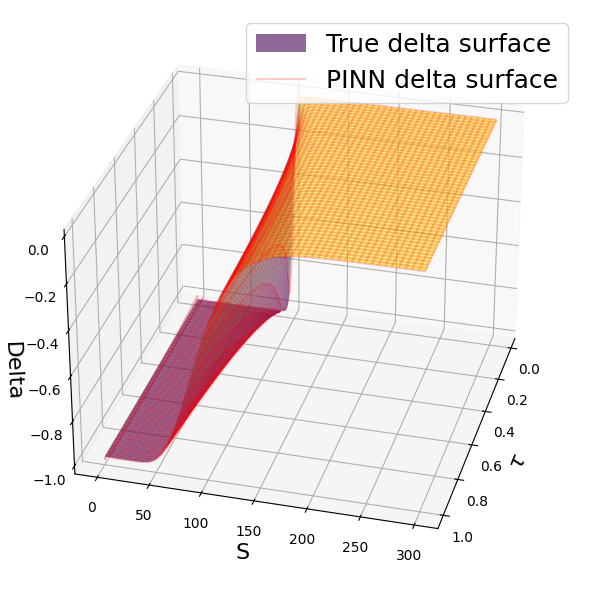

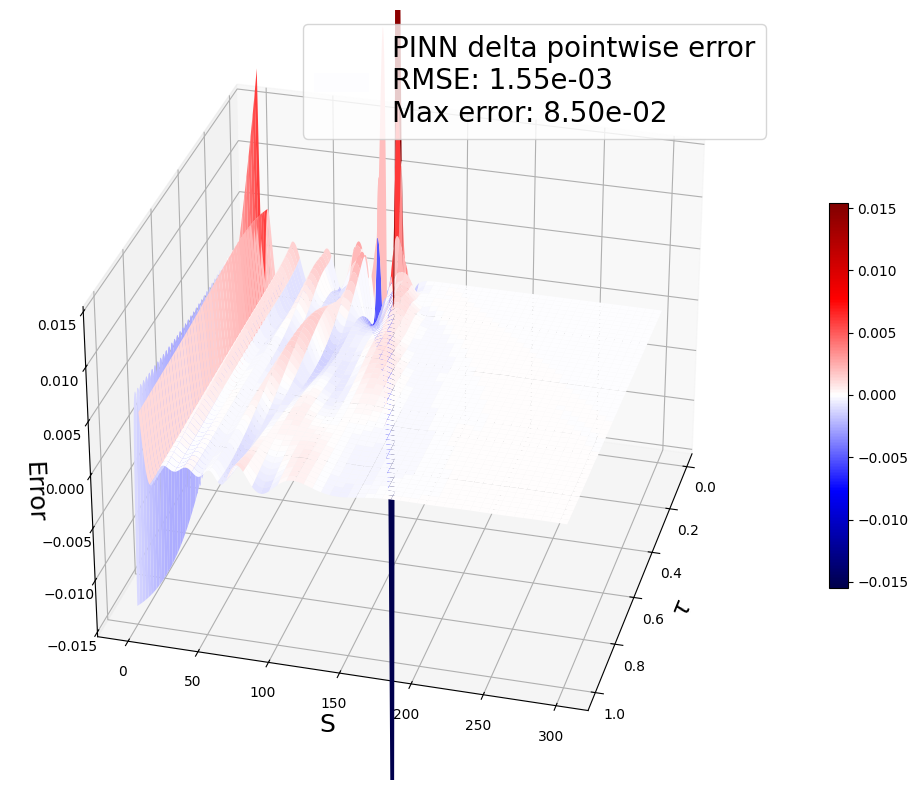

Theta RMSE: 0.13647541326642704
Theta MPE: 8.317078426353767


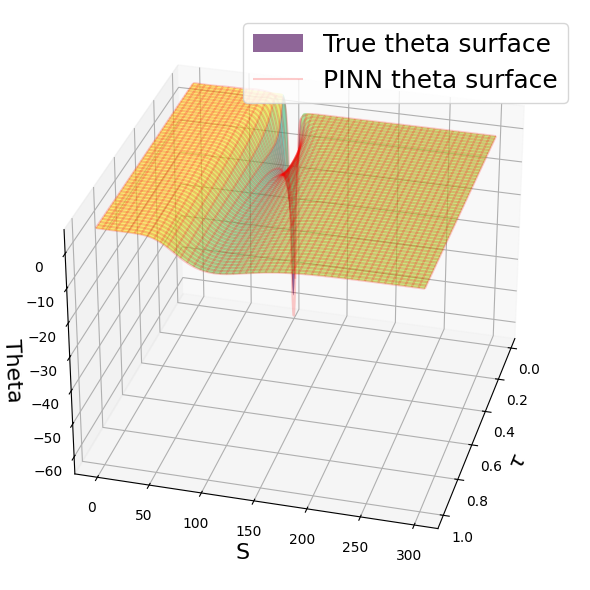

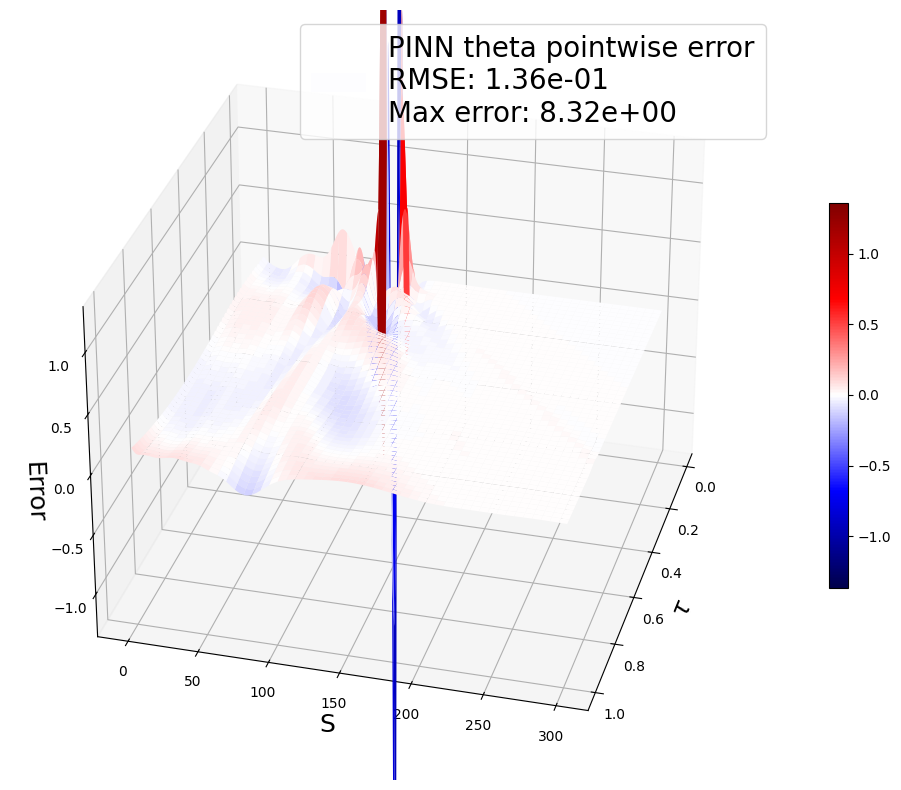

Gamma RMSE: 0.0009676179071834168
Gamma MPE: 0.052777919618173394


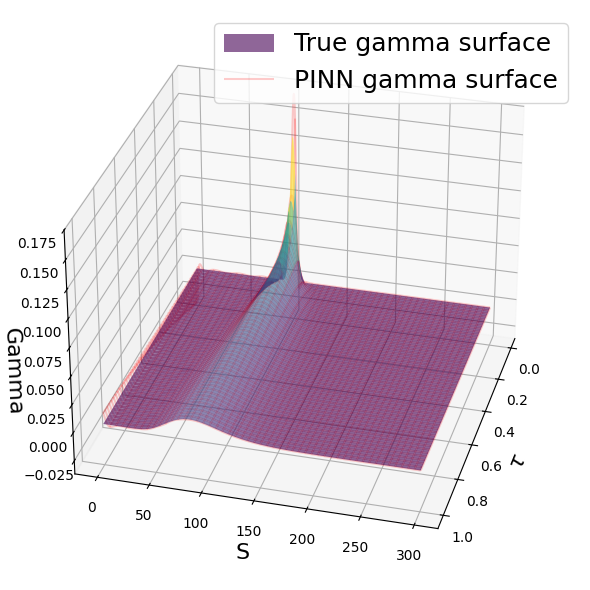

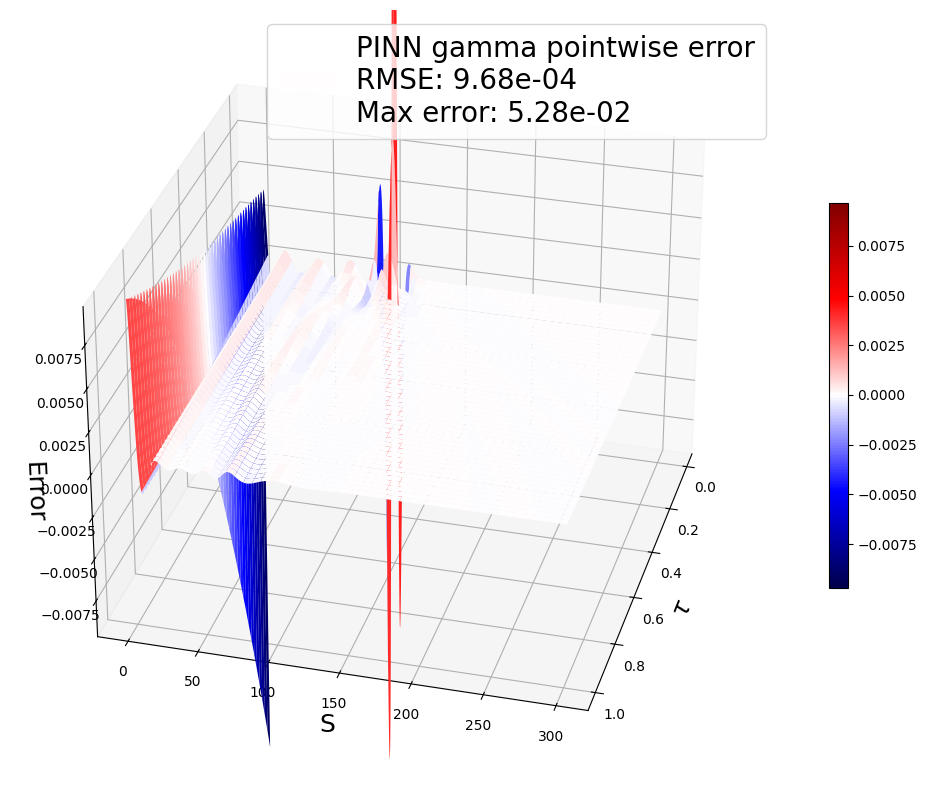

In [74]:
SAVE_FIG = True

epsilon = 1e-2
S_eval = torch.linspace(0, S_inf, 1000)
tau_eval = torch.linspace(epsilon, T, 1000)
S_eval, tau_eval = torch.meshgrid(S_eval, tau_eval, indexing='xy')
S_eval.requires_grad = True
tau_eval.requires_grad = True
S_eval_np = np.linspace(0, S_inf, 1000)
tau_eval_np = np.linspace(epsilon, T, 1000)
S_eval_np, tau_eval_np = np.meshgrid(S_eval_np, tau_eval_np)

for greek in ['Delta', 'Theta', 'Gamma']:
    greek_pred = model.evaluate_greeks(tau_eval.reshape(-1, 1), S_eval.reshape(-1, 1), greek).detach().cpu().numpy().reshape(1000, 1000)
    if np.isnan(greek_pred).any():
        raise ValueError(f'NaN in {greek}_pred')
    greek_true = european_option_greeks(tau_eval_np, S_eval_np, K, sigma, r, greek, 'put')
    greek_err = greek_pred - greek_true
    rmse_greek = np.sqrt(np.mean(greek_err**2))
    mpe_greek = np.max(np.abs(greek_err))
    print(f'{greek} RMSE:', rmse_greek)
    print(f'{greek} MPE:', mpe_greek)

    # plot greek surface
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(tau_eval_np, S_eval_np, greek_true,
                    label=f'True {greek.lower()} surface',
                    cmap='viridis', alpha=0.6)
    ax.plot_wireframe(tau_eval_np, S_eval_np, greek_pred,
                      label=f'PINN {greek.lower()} surface',
                      color='red', alpha=0.2)
    ax.set_xlabel(r'$\tau$', fontsize=16)
    ax.set_ylabel('S', fontsize=16)
    ax.set_zlabel(f'{greek}', fontsize=16)
    ax.view_init(elev=30, azim=15)
    plt.legend(fontsize=18, loc='upper right')
    plt.tight_layout()
    if SAVE_FIG:
        plt.savefig(f'./data/figures/{greek.lower()}_{FILE_NAME}.pdf', bbox_inches='tight')
    plt.show()

    scale = rmse_greek*10
    # plot greek error surface
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(tau_eval_np, S_eval_np, greek_err,
                           label=f'PINN {greek.lower()} pointwise error\nRMSE: {rmse_greek:.2e}\nMax error: {mpe_greek:.2e}',
                           cmap='seismic', vmin=-scale, vmax=scale, alpha=1)
    cbar = fig.colorbar(surf, location='right', shrink=0.5)
    ax.set_zlim(-scale, scale)
    ax.set_xlabel(r'$\tau$', fontsize=18)
    ax.set_ylabel('S', fontsize=18)
    ax.set_zlabel('Error', fontsize=18)
    # ax.set_zscale('symlog')
    plt.legend(fontsize=20, loc='upper right')
    ax.view_init(elev=30, azim=15)
    plt.tight_layout()
    if SAVE_FIG:
        plt.savefig(f'./data/figures/err_{greek.lower()}_{FILE_NAME}.pdf', bbox_inches='tight')
    plt.show()

### KAN

In [259]:
EFFICIENT_KAN = True  # use efficient KAN
if EFFICIENT_KAN:
    import KAN as kan  # efficient KAN
else:
    import kan  # original KAN

# parameters
TYPE = 'put'
STYLE = 'european'
K = 100
sigma = 0.3
r = 0.05
T = 1
S_inf = 3 * K

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = torch.load(f'./data/{STYLE}_{TYPE}_ib_sobol.pt', map_location=device)
tau_ib, S_ib, V_ib = data['tau'], data['S'], data['V']
print(f'Number of ib points: {len(tau_ib)}')

Number of ib points: 200


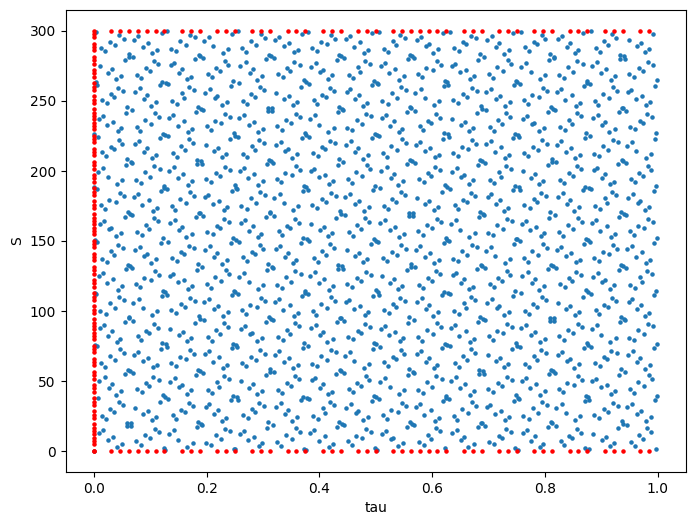

In [260]:
from PINN.utilities import collocation_points

SCALE = K / 10
N_pde = 2000
np.random.seed(128)
nn = kan.KAN([2,2,1]) if EFFICIENT_KAN else \
     kan.KAN(width=[2,2,1], grid=5, k=3, device=device)
model = VanillaOptionPINN(nn, K, T, sigma, r,
                          S_inf, scale=SCALE,
                          type=TYPE, style=STYLE,
                          device=device).to(device)
# print(model)

# sample collocation points
sobol = torch.quasirandom.SobolEngine(dimension=2)
tau_pde, S_pde = collocation_points(model, N_pde, sampling='sobol', sobol=sobol)

# plot
plt.figure(figsize=(8, 6))
plt.scatter(tau_pde.detach().numpy(), S_pde.detach().numpy(), s=5)
plt.scatter(tau_ib.detach().numpy(), S_ib.detach().numpy(), s=5, color='red')
plt.xlabel('tau')
plt.ylabel('S')
plt.show()

In [261]:
optimal_width = None
optimal_grid = None
optimal_params = None
min_eval_rmse = float('inf')
eval_mpe = 0.

In [268]:
WIDTH = [2, 4, 4, 2, 1]
GRID0 = 8
BASE_ACTIVATION = torch.nn.Tanh
np.random.seed()
if EFFICIENT_KAN:
    nn = kan.KAN(WIDTH, grid_size=GRID0, spline_order=3,
                 grid_range=[0, 100],  # [-1, 1]
                 base_activation=BASE_ACTIVATION)
else:
    # grid_eps=0. for adaptive grid based on sample distribution
    # grid_eps=1 for uniform grid
    nn = kan.KAN(width=WIDTH, grid=GRID0, k=3, grid_eps=0.)
print(nn)
print('Number of parameters:', sum(p.numel() for p in nn.parameters()))

KAN(
  (layers): ModuleList(
    (0-3): 4 x KANLinear(
      (base_activation): Tanh()
    )
  )
)
Number of parameters: 442


In [269]:
REFINE = False and not EFFICIENT_KAN  # for original KAN only
EPOCHS_LBFGS = 500
EPOCHS_ADAM = 500
LR_ADAM = 1e-2
EARLY_STOPPING = 50
SPEED = True
log = 1
# PINN parameters
SCALE = K / 10
N_pde = 2000
# ---
if REFINE:
    grids = [100]
else:
    grids = [GRID0]
    loss_history = {'ib': [], 'pde': [], 'total': []}


for grid in grids:
    print(model.V_nn)
    if not REFINE:
        nn = nn.speed() if SPEED and not EFFICIENT_KAN else nn
        model = VanillaOptionPINN(nn, K, T, sigma, r,
                                  S_inf, scale=SCALE,
                                  type=TYPE, style=STYLE,
                                  device=device).to(device)
        print('Number of parameters:', sum(p.numel() for p in model.parameters()))
    else:
        model.V_nn.save_act = True
        model.V_nn.get_act(torch.cat((tau_pde, S_pde), dim=1))
        model.V_nn = model.V_nn.refine(grid)
        model.V_nn = model.V_nn.speed() if SPEED else model.V_nn

    def train(epochs, optimizer='lbfgs', lr=1e-3):
        optimzer = optimizer.lower()
        if optimzer == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        elif optimzer == 'lbfgs':
            if EFFICIENT_KAN:
                optimizer = torch.optim.LBFGS(model.parameters(),
                                              lr=1., max_iter=20, history_size=100,
                                              line_search_fn="strong_wolfe")
            else:
                optimizer = kan.LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe",
                                      tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
        pbar = tqdm(range(epochs), desc='description', ncols=100)
        patience = 0
        min_loss = float('inf')
        for _ in pbar:
            def closure():
                global loss_ib, loss_pde
                optimizer.zero_grad()
                loss_ib, loss_pde, loss_data = model.loss(tau_ib, S_ib, V_ib,
                                                 tau_pde, S_pde)
                loss = loss_ib + loss_pde
                loss.backward(retain_graph=True)
                return loss

            # for original KAN
            if not EFFICIENT_KAN and _ % 5 == 0 and _ < 20:
                model.V_nn.update_grid_from_samples(torch.cat((tau_pde, S_pde), dim=1))

            loss = optimizer.step(closure).cpu().detach().numpy()
            if np.isnan(loss):
                print(f'NaN loss detected at epoch {_ + 1}')
                return
            if loss >= min_loss or np.isclose(loss, min_loss, rtol=1e-5, atol=1e-8):
                patience += 1
                if patience >= EARLY_STOPPING:
                    print(f'Early stopping at epoch {_ + 1}')
                    break
            else:
                min_loss, patience = loss, 0

            if _ % log == 0:
                pbar.set_description("pde loss: %.2e | ib loss: %.2e | total: %.2e " % (loss_pde.cpu().detach().numpy(), loss_ib.cpu().detach().numpy(), loss))

            loss_history['ib'].append(loss_ib.cpu().detach().numpy())
            loss_history['pde'].append(loss_pde.cpu().detach().numpy())
            loss_history['total'].append(loss)

    train(EPOCHS_ADAM, optimizer='adam', lr=LR_ADAM) if EFFICIENT_KAN else None
    train(EPOCHS_LBFGS, optimizer='lbfgs')

KAN(
  (layers): ModuleList(
    (0-2): 3 x KANLinear(
      (base_activation): Tanh()
    )
  )
)
Number of parameters: 442


pde loss: 1.62e-02 | ib loss: 1.45e-02 | total: 3.07e-02 : 100%|██| 500/500 [00:32<00:00, 15.38it/s]
pde loss: 2.27e-04 | ib loss: 2.97e-04 | total: 5.24e-04 :  33%|▋ | 166/500 [02:56<05:55,  1.07s/it]

Early stopping at epoch 167


In [270]:
SAVE_FIG = True
KAN_NAME = 'KAN' + str(WIDTH[1:-1]).replace(' ', '').replace('[', '(').replace(']', ')') + f'_grid{grid}'
print(KAN_NAME)

KAN(4,4,2)_grid8


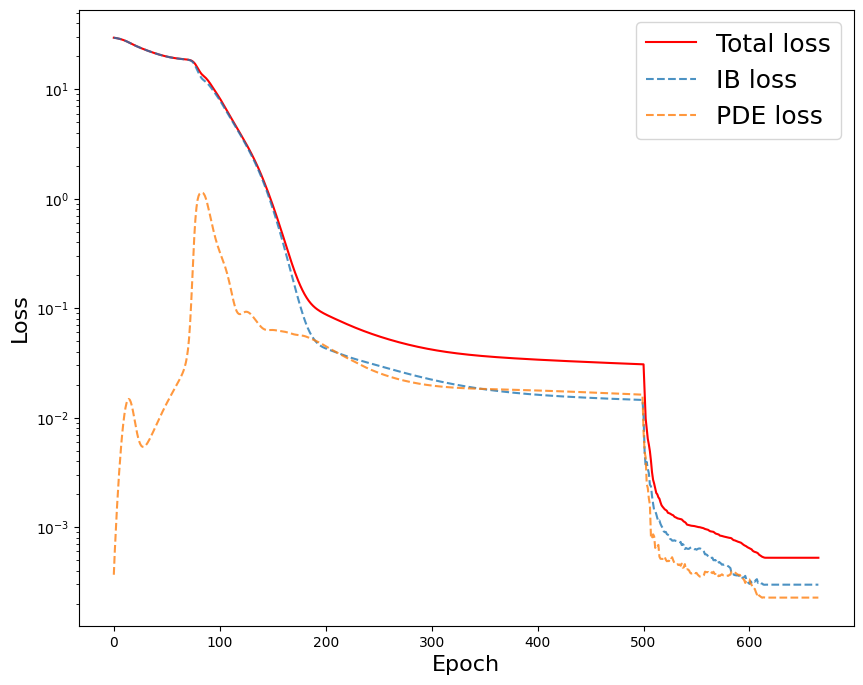

In [271]:
# plot loss history
plt.figure(figsize=(10, 8))
plt.plot(loss_history['total'], label='Total loss', c='red')
plt.plot(loss_history['ib'], label='IB loss', ls='--', alpha=0.8)
plt.plot(loss_history['pde'], label='PDE loss', ls='--', alpha=0.8)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.yscale('log')
plt.legend(fontsize=18)
if SAVE_FIG:
    plt.savefig(f'./data/figures/loss_{STYLE}_{TYPE}_{KAN_NAME}.pdf', bbox_inches='tight')
plt.show()

Current width: [2, 4, 4, 2, 1]
Current grid: 8
Current num of parameters: 442
Optimal width: [2, 4, 4, 1]
Optimal grid: 16
Min RMSE: 0.026282403603888758
with MPE: 1.5548322801550043
Current MPE 1.892447293277563
MPE at: 0.0 100.0


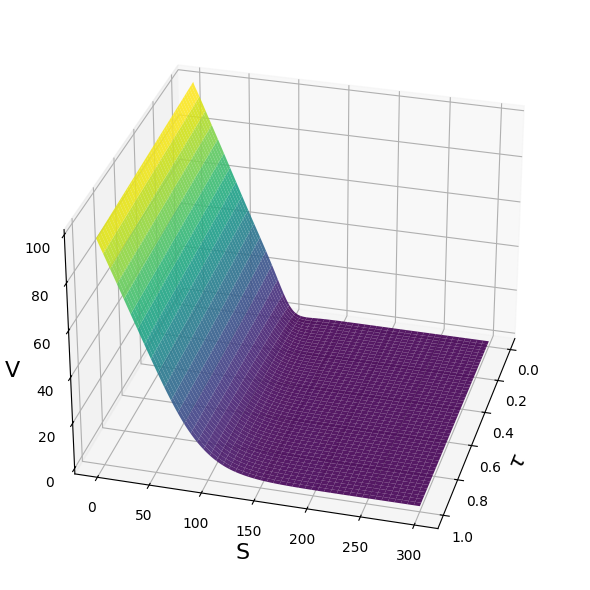

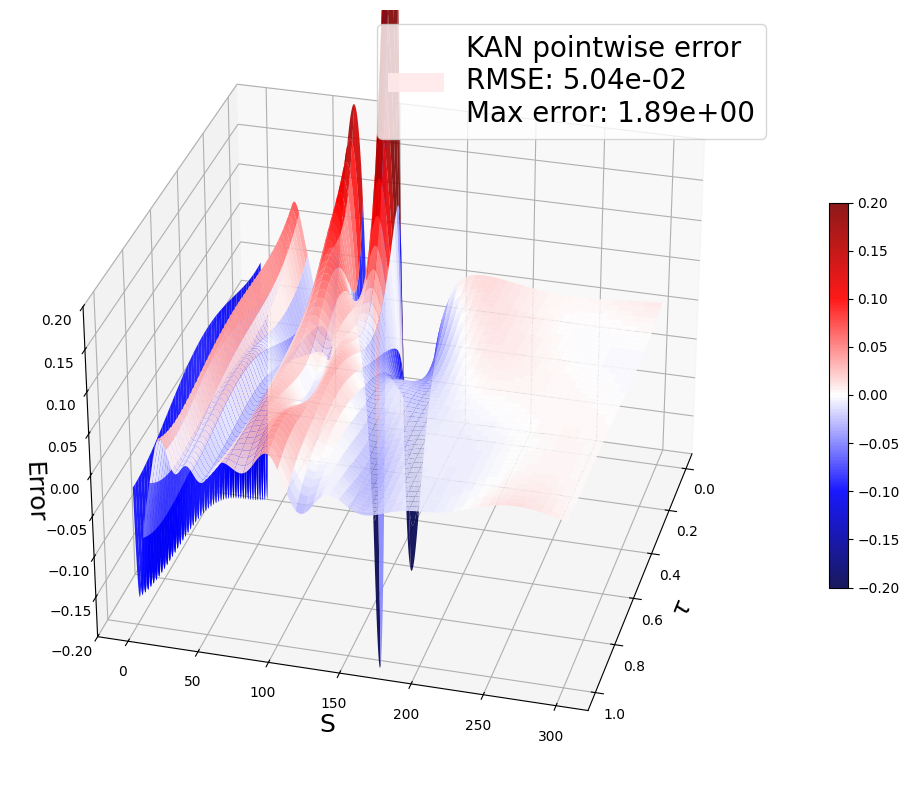

In [272]:
# MLP benchmark RMSE 8e-3 ~ 1e-2
S_eval = torch.linspace(0, S_inf, 1000)
tau_eval = torch.linspace(0, T, 1000)
S_eval, tau_eval = torch.meshgrid(S_eval, tau_eval, indexing='xy')
if not EFFICIENT_KAN:
    model.V_nn.save_act = True
V_pred = model(tau_eval.reshape(-1, 1), S_eval.reshape(-1, 1)).detach().numpy().reshape(1000, 1000)
model.V_nn.plot() if not EFFICIENT_KAN else None
print('Current width:', WIDTH)
print('Current grid:',grid)
print('Current num of parameters:', sum(p.numel() for p in model.parameters()))

S_eval = np.linspace(0, S_inf, 1000)
tau_eval = np.linspace(0, T, 1000)
S_eval, tau_eval = np.meshgrid(S_eval, tau_eval)
V_true = V_BS(tau_eval, S_eval, K, sigma, r, 'put')
V_err = V_pred - V_true
mse = np.mean(V_err**2)
rmse = np.sqrt(mse)
mpe = np.max(np.abs(V_err))
if rmse < min_eval_rmse:
    min_eval_rmse = rmse
    eval_mpe = mpe
    optimal_width = WIDTH
    optimal_grid = grid
    optimal_params = sum(p.numel() for p in model.parameters())
print('Optimal width:', optimal_width)
print('Optimal grid:', optimal_grid)
print('Min RMSE:', min_eval_rmse)
print('with MPE:', eval_mpe)
print('Current MPE', mpe)
idx = np.unravel_index(np.argmax(np.abs(V_err)), V_err.shape)
print('MPE at:', tau_eval[idx], S_eval[idx])

# 3d plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, V_pred,
                       cmap='viridis', alpha=0.9)
ax.set_xlabel(r'$\tau$', fontsize=16)
ax.set_ylabel('S', fontsize=16)
ax.set_zlabel('V', fontsize=16)
ax.view_init(elev=30, azim=15)
plt.tight_layout()
plt.show()

# plot error surface
scale = 0.2
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, V_err,
                       label=f'KAN pointwise error\nRMSE: {rmse:.2e}\nMax error: {mpe:.2e}',
                       cmap='seismic', vmin=-scale, vmax=scale, alpha=0.9)
cbar = fig.colorbar(surf, location='right', shrink=0.5)
ax.set_zlim(-scale, scale)
ax.set_xlabel(r'$\tau$', fontsize=18)
ax.set_ylabel('S', fontsize=18)
ax.set_zlabel('Error', fontsize=18)
# ax.set_zscale('symlog')
plt.legend(fontsize=20, loc='upper right')
ax.view_init(elev=30, azim=15)
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(f'./data/figures/err_{STYLE}_{TYPE}_{KAN_NAME}.pdf', bbox_inches='tight')
plt.show()

In [267]:
# SAVE_FIG = False

# epsilon = 1e-2
# S_eval = torch.linspace(0, S_inf, 1000)
# tau_eval = torch.linspace(epsilon, T, 1000)
# S_eval, tau_eval = torch.meshgrid(S_eval, tau_eval, indexing='xy')
# S_eval.requires_grad = True
# tau_eval.requires_grad = True
# S_eval_np = np.linspace(0, S_inf, 1000)
# tau_eval_np = np.linspace(epsilon, T, 1000)
# S_eval_np, tau_eval_np = np.meshgrid(S_eval_np, tau_eval_np)

# for greek in ['Delta', 'Theta', 'Gamma']:
#     greek_pred = model.evaluate_greeks(tau_eval.reshape(-1, 1), S_eval.reshape(-1, 1), greek).detach().cpu().numpy().reshape(1000, 1000)
#     if np.isnan(greek_pred).any():
#         raise ValueError(f'NaN in {greek}_pred')
#     greek_true = european_option_greeks(tau_eval_np, S_eval_np, K, sigma, r, greek, 'put')
#     greek_err = greek_pred - greek_true
#     rmse_greek = np.sqrt(np.mean(greek_err**2))
#     mpe_greek = np.max(np.abs(greek_err))
#     print(f'{greek} RMSE:', rmse_greek)
#     print(f'{greek} MPE:', mpe_greek)

#     # plot greek surface
#     fig = plt.figure(figsize=(8, 6))
#     ax = fig.add_subplot(111, projection='3d')
#     ax.plot_surface(tau_eval_np, S_eval_np, greek_true,
#                     label=f'True {greek.lower()} surface',
#                     cmap='viridis', alpha=0.6)
#     ax.plot_wireframe(tau_eval_np, S_eval_np, greek_pred,
#                       label=f'PINN {greek.lower()} surface',
#                       color='red', alpha=0.2)
#     ax.set_xlabel(r'$\tau$', fontsize=16)
#     ax.set_ylabel('S', fontsize=16)
#     ax.set_zlabel(f'{greek}', fontsize=16)
#     ax.view_init(elev=30, azim=15)
#     plt.legend(fontsize=18, loc='upper right')
#     plt.tight_layout()
#     if SAVE_FIG:
#         plt.savefig(f'./data/figures/{greek.lower()}_{STYLE}_{TYPE}_kan.pdf', bbox_inches='tight')
#     plt.show()

#     scale = rmse_greek*10
#     # plot greek error surface
#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(111, projection='3d')
#     surf = ax.plot_surface(tau_eval_np, S_eval_np, greek_err,
#                            label=f'PINN {greek.lower()} pointwise error\nRMSE: {rmse_greek:.2e}\nMax error: {mpe_greek:.2e}',
#                            cmap='seismic', vmin=-scale, vmax=scale, alpha=1)
#     cbar = fig.colorbar(surf, location='right', shrink=0.5)
#     ax.set_zlim(-scale, scale)
#     ax.set_xlabel(r'$\tau$', fontsize=18)
#     ax.set_ylabel('S', fontsize=18)
#     ax.set_zlabel('Error', fontsize=18)
#     # ax.set_zscale('symlog')
#     plt.legend(fontsize=20, loc='upper right')
#     ax.view_init(elev=30, azim=15)
#     plt.tight_layout()
#     if SAVE_FIG:
#         plt.savefig(f'./data/figures/err_{greek.lower()}_{STYLE}_{TYPE}_kan.pdf', bbox_inches='tight')
#     plt.show()

## American Put Option

In [2]:
# parameters
TYPE = 'put'
STYLE = 'american'
K = 100
sigma = 0.3
r = 0.05
T = 1
S_inf = 3 * K

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load results
ARCHITECTURE = 'test'
MODEL_PATH = f'./models/{STYLE}_{TYPE}_{ARCHITECTURE}/'
FILE_NAME = f'{STYLE}_{TYPE}_{ARCHITECTURE}.npy'
results = np.load(f'data/output/{FILE_NAME}', allow_pickle=True).item()
RMSE = results['RMSE']
MPE = results['MPE']  # max pointwise error

idx = [i for i in range(len(RMSE)) if RMSE[i] < 1]
RMSE_mean = RMSE[idx].mean()
RMSE_std = RMSE[idx].std()
RMSE_mean_std = {'mean': RMSE_mean, 'std': RMSE_std}
mpe_mean = MPE[idx].mean()
mpe_std = MPE[idx].std()
best_idx = np.argmin(RMSE)

GREEKS = results['GREEKS']
RMSE_greeks = {}
MPE_greeks = {}
for greek in GREEKS:
    RMSE_greeks[greek] = results[f'RMSE_{greek}']
    MPE_greeks[greek] = results[f'MPE_{greek}']
RMSE_greeks_mean = {greek: RMSE_greeks[greek].mean() for greek in GREEKS}
RMSE_greeks_std = {greek: RMSE_greeks[greek].std() for greek in GREEKS}
mpe_greeks_mean = {greek: MPE_greeks[greek].mean() for greek in GREEKS}
mpe_greeks_std = {greek: MPE_greeks[greek].std() for greek in GREEKS}

SEEDS = results['SEEDS']

model_name = f'{STYLE}_{TYPE}_{best_idx}'
model = torch.load(MODEL_PATH+f'{model_name}.pt', map_location=device)

VanillaOptionPINN(
  (V_nn): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): Tanh()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): Tanh()
    (8): Linear(in_features=10, out_features=1, bias=True)
  )
)
Number of parameters: 371


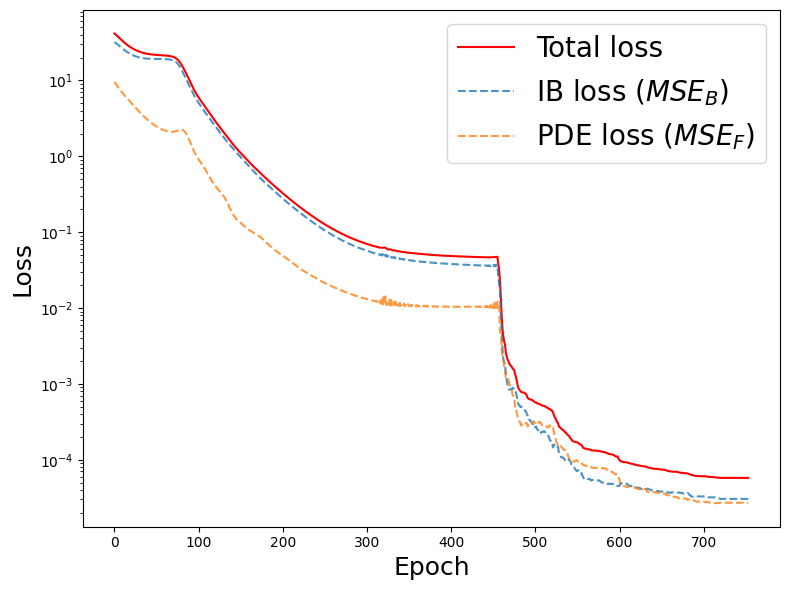

Final loss: 5.760833482781891e-05


In [6]:
print(model)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))
model.plot_history(save=False, title='', figsize=(8, 6), fontsize=18, file_name=f'data/figures/loss_{FILE_NAME}.pdf')
print('Final loss:', model.loss_history['total'][-1])

### Comparison with Crank-Nicolson and QuantLib

MPE 0.2906625196668813
MPE at: 1.0 66.674446


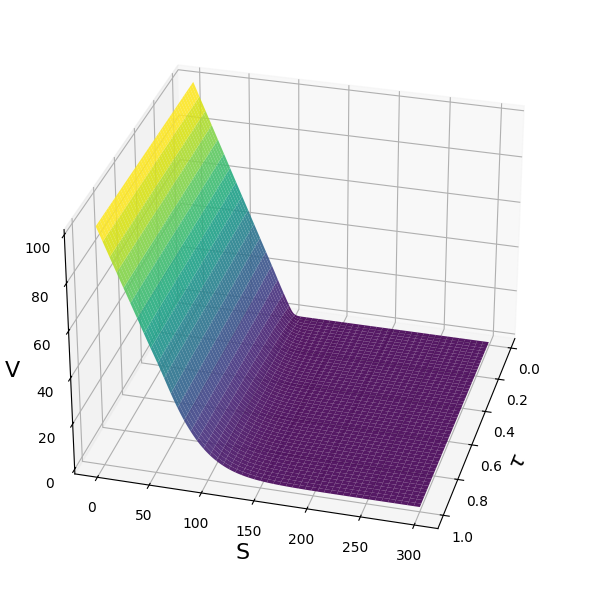

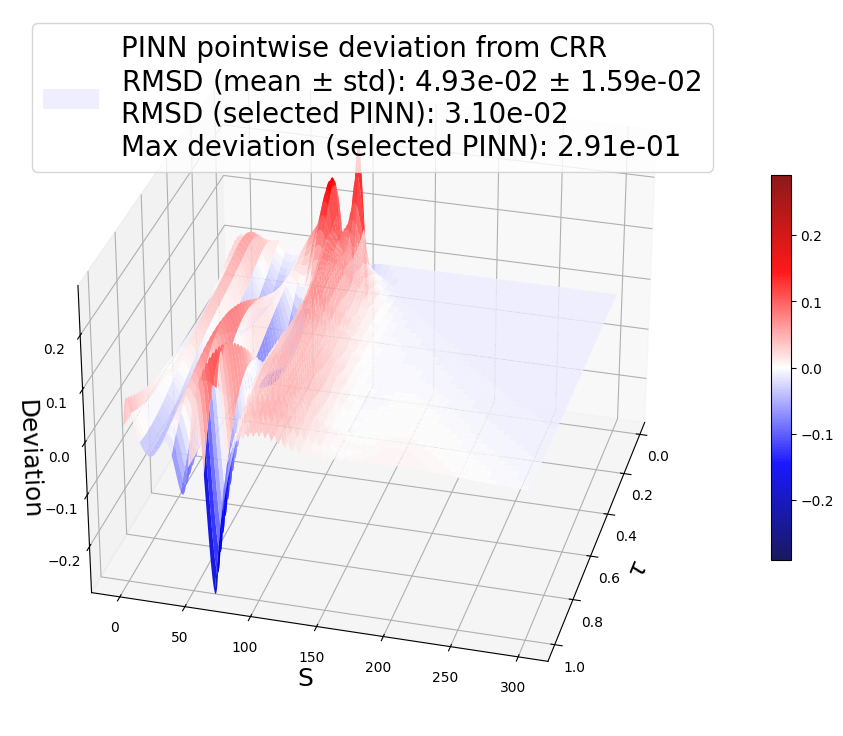

In [35]:
from scipy.interpolate import RegularGridInterpolator

SAVE_FIG = True
REF = 'CRR'
# REF = 'CRR'

if REF == 'CRR':
    # epsilon = 1e-2
    # tau_eval = np.linspace(0, T, 365)[1:]
    # S_eval = np.linspace(epsilon, S_inf, 1000)
    # V_ql, tau_eval, S_eval = V_quantlib(tau_eval, S_eval, K, T, sigma, r,
    #                                     type='put', style='american',
    #                                     method='crr')
    # interpolate QuantLib solution on eval grid
    # tau_eval = np.linspace(0, T, 365)[1:]
    # S_eval = np.linspace(epsilon, S_inf, 1000)
    # interpolator = RegularGridInterpolator((tau_eval, S_eval), V_ql, method='linear', bounds_error=False, fill_value=np.nan)
    # S_eval, tau_eval = np.meshgrid(np.linspace(epsilon, S_inf, 1000), np.linspace(epsilon, T, 1000))
    # V_ql = interpolator((tau_eval, S_eval))
    # np.save(f'data/output/american_put_ql.npy', {'V': V_ql, 'tau': tau_eval, 'S': S_eval})
    ql = np.load(f'data/output/american_put_ql.npy', allow_pickle=True).item()
    tau_eval = ql['tau']
    S_eval = ql['S']
    V_ref = ql['V']
else:
    tau_eval = torch.linspace(0, T, 1000)
    S_eval = torch.linspace(0, S_inf, 1000)
    S_eval, tau_eval = np.meshgrid(np.linspace(0, S_inf, 1000), np.linspace(0, T, 1000))
    V_CN, t_CN, S_CN = V_BS_CN(100, 100, K, T, sigma, r, S_inf, TYPE, STYLE)
    interpolator = RegularGridInterpolator((t_CN, S_CN), V_CN, method='linear', bounds_error=False, fill_value=np.nan)
    V_ref = interpolator((tau_eval, S_eval))

tau_eval = torch.tensor(tau_eval, dtype=torch.float32, requires_grad=True)
S_eval = torch.tensor(S_eval, dtype=torch.float32, requires_grad=True)
V_pred = model(tau_eval.reshape(-1, 1), S_eval.reshape(-1, 1)).detach().numpy().reshape(tau_eval.shape)
tau_eval = tau_eval.detach().numpy()
S_eval = S_eval.detach().numpy()

diff = V_pred - V_ref
rmse = np.sqrt(np.mean(diff**2))
mpe = np.max(np.abs(diff))
print('MPE', mpe)
idx = np.unravel_index(np.argmax(np.abs(diff)), diff.shape)
print('MPE at:', tau_eval[idx], S_eval[idx])

# plot sol
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, V_pred,
                       cmap='viridis', alpha=0.9)
intrinsic = np.maximum(K - S_eval, 0)
# # plot intrinsic value
# ax.plot_surface(tau_eval, S_eval, intrinsic,
#                    label='Intrinsic value',
#                    color='black', alpha=0.9)
# # plot stopping region
# mask = np.isclose(V_ref, intrinsic, atol=1e-2)
# S_star = np.where(mask, S_eval, np.nan)
# tau_star = np.where(mask, tau_eval, np.nan)
# ax.plot_surface(tau_star, S_star, intrinsic,
#                   label='Stopping region',
#                   color='black', alpha=0.5)
# # plot european counterpart
# V_eu = V_BS(tau_eval, S_eval, K, sigma, r, 'put')
# ax.plot_surface(tau_eval, S_eval, V_eu,
#                   label='European counterpart',
#                   color='red', alpha=0.5)

ax.set_xlabel(r'$\tau$', fontsize=16)
ax.set_ylabel('S', fontsize=16)
ax.set_zlabel('V', fontsize=16)
ax.view_init(elev=30, azim=15)
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(f'./data/figures/sol_{STYLE}_{TYPE}.pdf', bbox_inches='tight')
plt.show()

# plot diff surface
scale = mpe
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, diff,
                       label=f'PINN pointwise deviation from {REF}\nRMSD (mean $\pm$ std): {RMSE_mean:.2e} $\pm$ {RMSE_std:.2e}\nRMSD (selected PINN): {rmse:.2e}\nMax deviation (selected PINN): {mpe:.2e}',
                       cmap='seismic', vmin=-scale, vmax=scale, alpha=0.9)
cbar = fig.colorbar(surf, location='right', shrink=0.5)
ax.set_zlim(-scale, scale)
ax.set_xlabel(r'$\tau$', fontsize=18)
ax.set_ylabel('S', fontsize=18)
ax.set_zlabel('Deviation', fontsize=18)
# ax.set_zscale('symlog')
plt.legend(fontsize=20, loc='upper right')
ax.view_init(elev=30, azim=15)
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(f'./data/figures/err_{STYLE}_{TYPE}_{REF}.pdf', bbox_inches='tight')

#### Verify Modified Crank-Nicolson with QuantLib

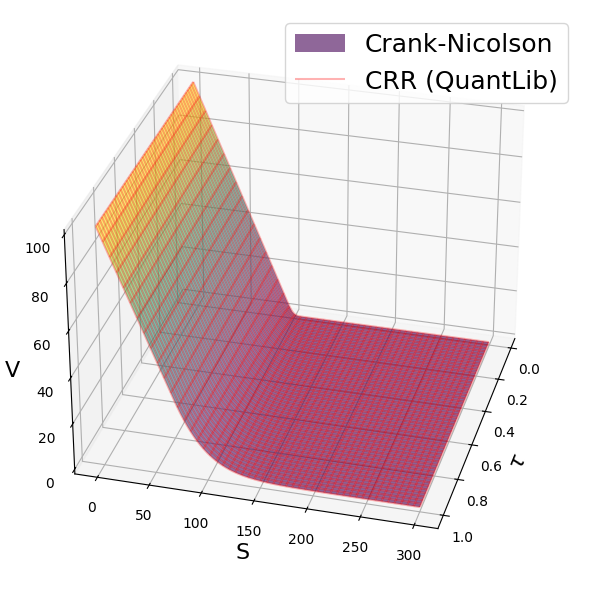

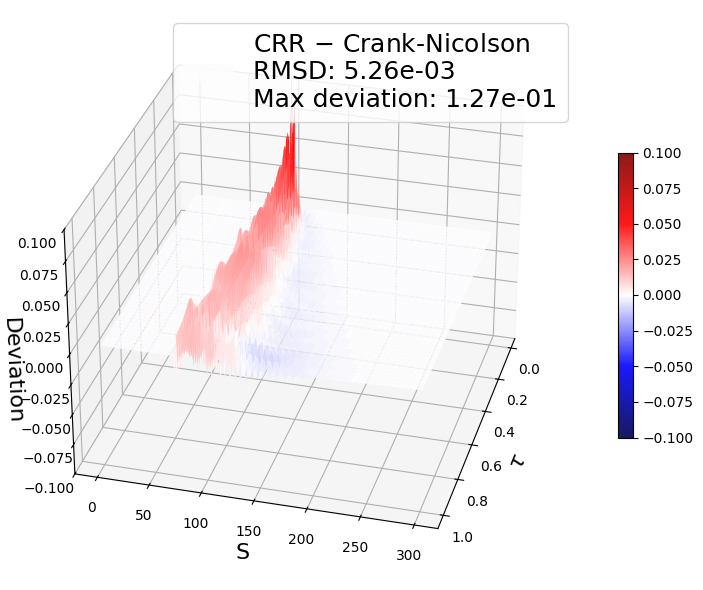

In [ ]:
from scipy.interpolate import RegularGridInterpolator


# QuantLib solution
ql = np.load(f'data/output/american_put_ql.npy', allow_pickle=True).item()
tau_eval = ql['tau']
S_eval = ql['S']
V_ql = ql['V']

# Euroean counterpart
V_eu = V_BS(tau_eval, S_eval, K, sigma, r, 'put')

# Crank-Nicolson solution
V_CN, t_CN, S_CN = V_BS_CN(100, 100, K, T, sigma, r, S_inf, type='put', style='american')
# interpolate CN solution on eval grid
interpolator = RegularGridInterpolator((t_CN, S_CN), V_CN, method='linear', bounds_error=False, fill_value=np.nan)
V_CN = interpolator((tau_eval, S_eval))

# plot solutions
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(tau_eval, S_eval, V_eu,
#                   label='European counterpart',
#                   cmap='cividis', alpha=0.6)
ax.plot_surface(tau_eval, S_eval, V_CN,
                label='Crank-Nicolson',
                cmap='viridis', alpha=0.6)
ax.plot_wireframe(tau_eval, S_eval, V_ql,
                  label='CRR (QuantLib)',
                  color='red', alpha=0.3)
ax.set_xlabel(r'$\tau$', fontsize=16)
ax.set_ylabel('S', fontsize=16)
ax.set_zlabel('V', fontsize=16)
ax.view_init(elev=30, azim=15)
plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig(f'./data/figures/sol_cn_ql.pdf', bbox_inches='tight')
plt.show()

# plot diff
diff = V_ql - V_CN
mpe = np.max(np.abs(diff))
rmse = np.sqrt(np.mean(diff**2))
scale = 0.1
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, diff,
                       label=f'CRR $-$ Crank-Nicolson\nRMSD: {rmse:.2e}\nMax deviation: {mpe:.2e}',
                       cmap='seismic', vmin=-scale, vmax=scale, alpha=0.9)
cbar = fig.colorbar(surf, location='right', shrink=0.5)
ax.set_zlim(-scale, scale)
ax.set_xlabel(r'$\tau$', fontsize=16)
ax.set_ylabel('S', fontsize=16)
ax.set_zlabel('Deviation', fontsize=16)
ax.view_init(elev=30, azim=15)
plt.legend(fontsize=18, loc='upper right')
plt.tight_layout()
plt.savefig(f'./data/figures/err_cn_ql.pdf', bbox_inches='tight')
plt.show()

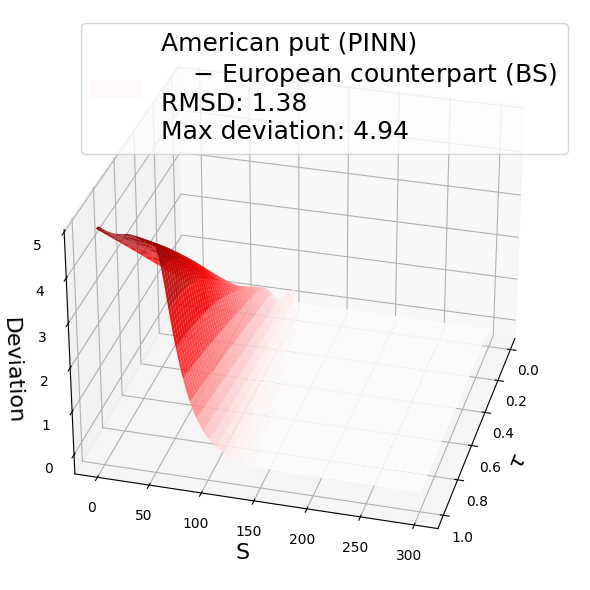

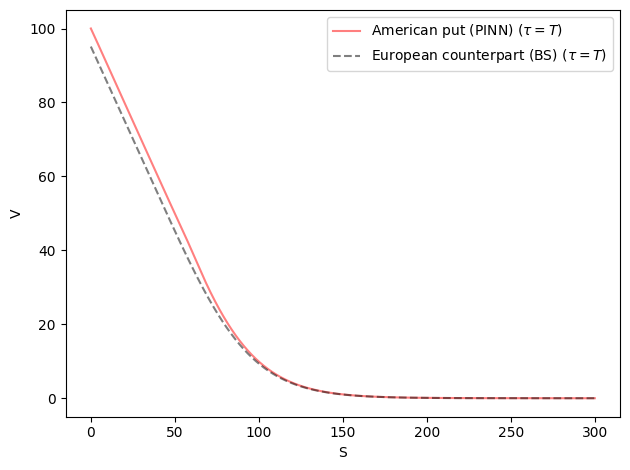

In [20]:
SAVE_FIG = True
REF = 'PINN'

if REF.lower() == 'pinn':
    tau_eval = torch.linspace(0, T, 1000)
    S_eval = torch.linspace(0, S_inf, 1000)
    S_eval, tau_eval = torch.meshgrid(S_eval, tau_eval, indexing='xy')
    V_ref = model(tau_eval.reshape(-1, 1), S_eval.reshape(-1, 1)).detach().numpy().reshape(1000, 1000)
    tau_eval = tau_eval.detach().numpy()
    S_eval = S_eval.detach().numpy()
elif REF.lower() == 'quantlib':
    # epsilon = 1e-2
    # tau_eval = np.linspace(0, T, 365)[1:]
    # S_eval = np.linspace(epsilon, S_inf, 1000)
    # V_ql, tau_eval, S_eval = V_quantlib(tau_eval, S_eval, K, T, sigma, r,
    #                                     type='put', style='american',
    #                                     method='crr')
    # np.save(f'data/output/american_put_ql.npy', {'V': V_ql, 'tau': tau_eval, 'S': S_eval})
    ql = np.load(f'data/output/american_put_ql.npy', allow_pickle=True).item()
    V_ref = ql['V']
    tau_eval = ql['tau']
    S_eval = ql['S']
else:
    S_eval, tau_eval = np.meshgrid(np.linspace(0, S_inf, 1000), np.linspace(0, T, 1000))
    V_CN, t_CN, S_CN = V_BS_CN(100, 100, K, T, sigma, r, S_inf, TYPE, STYLE)
    interpolator = RegularGridInterpolator((t_CN, S_CN), V_CN, method='linear', bounds_error=False, fill_value=np.nan)
    V_ref = interpolator((tau_eval, S_eval))

# Euroean counterpart
V_eu = V_BS(tau_eval, S_eval, K, sigma, r, 'put')


# plot diff
diff = V_ref - V_eu
mpe = np.max(np.abs(diff))
rmse = np.sqrt(np.mean(diff**2))
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, diff,
                       label=f'American put (PINN)\n    $-$ European counterpart (BS)\nRMSD: {rmse:.2f}\nMax deviation: {mpe:.2f}',
                       cmap='seismic', vmin=-mpe, vmax=mpe, alpha=0.9)
ax.set_xlabel(r'$\tau$', fontsize=16)
ax.set_ylabel('S', fontsize=16)
ax.set_zlabel('Deviation', fontsize=16)
ax.view_init(elev=30, azim=15)
plt.legend(fontsize=18)
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(f'./data/figures/diff_{STYLE}_{TYPE}_{REF}.pdf', bbox_inches='tight')
plt.show()

# Plot solution at tau=T
plt.plot(S_eval[0, :], V_ref[-1, :], label=r'American put (PINN) ($\tau=T$)', alpha=0.5, c='r')
plt.plot(S_eval[0, :], V_eu[-1, :], label=r'European counterpart (BS) ($\tau=T$)', alpha=0.5, c='k', ls='--')
plt.legend()
plt.xlabel('S')
plt.ylabel('V')
plt.tight_layout()
plt.show()

### Greeks

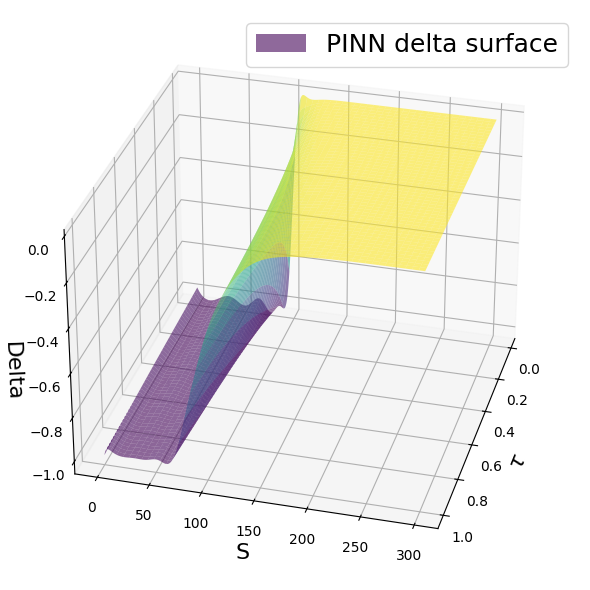

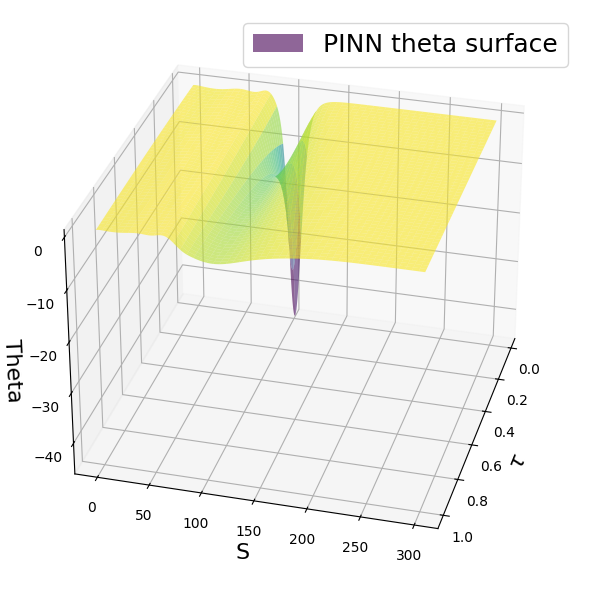

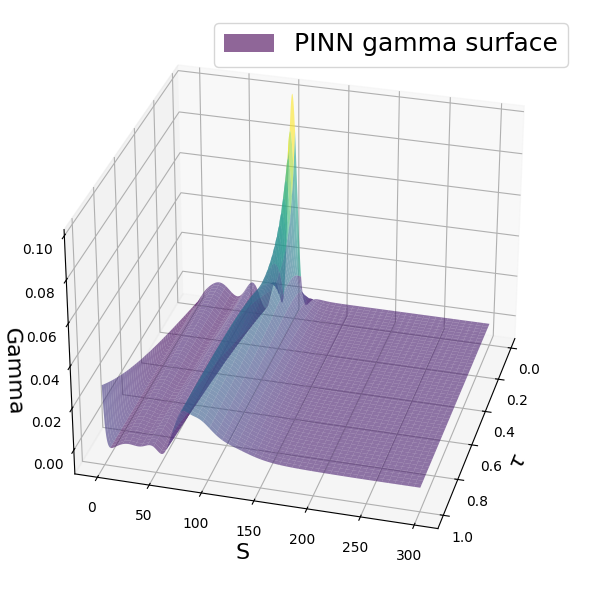

In [101]:
SAVE_FIG = False

epsilon = 1e-2
S_eval = torch.linspace(0, S_inf, 1000)
tau_eval = torch.linspace(epsilon, T, 1000)
S_eval, tau_eval = torch.meshgrid(S_eval, tau_eval, indexing='xy')
S_eval.requires_grad = True
tau_eval.requires_grad = True
S_eval_np = np.linspace(0, S_inf, 1000)
tau_eval_np = np.linspace(epsilon, T, 1000)
S_eval_np, tau_eval_np = np.meshgrid(S_eval_np, tau_eval_np)

for greek in ['Delta', 'Theta', 'Gamma']:
    greek_pred = model.evaluate_greeks(tau_eval.reshape(-1, 1), S_eval.reshape(-1, 1), greek).detach().cpu().numpy().reshape(1000, 1000)
    if np.isnan(greek_pred).any():
        raise ValueError(f'NaN in {greek}_pred')
    # greek_true = european_option_greeks(tau_eval_np, S_eval_np, K, sigma, r, greek, 'put')
    # greek_err = greek_pred - greek_true
    # rmse_greek = np.sqrt(np.mean(greek_err**2))
    # mpe_greek = np.max(np.abs(greek_err))
    # print(f'{greek} RMSE:', rmse_greek)
    # print(f'{greek} MPE:', mpe_greek)

    # plot greek surface
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    # ax.plot_surface(tau_eval_np, S_eval_np, greek_true,
    #                 label=f'True {greek.lower()} surface',
    #                 cmap='viridis', alpha=0.6)
    # ax.plot_wireframe(tau_eval_np, S_eval_np, greek_pred,
    #                   label=f'PINN {greek.lower()} surface',
    #                   color='red', alpha=0.2)
    ax.plot_surface(tau_eval_np, S_eval_np, greek_pred,
                      label=f'PINN {greek.lower()} surface',
                      cmap='viridis', alpha=0.6)
    ax.set_xlabel(r'$\tau$', fontsize=16)
    ax.set_ylabel('S', fontsize=16)
    ax.set_zlabel(f'{greek}', fontsize=16)
    ax.view_init(elev=30, azim=15)
    plt.legend(fontsize=18, loc='upper right')
    plt.tight_layout()
    if SAVE_FIG:
        plt.savefig(f'./data/figures/{greek.lower()}_{FILE_NAME}.pdf', bbox_inches='tight')
    plt.show()

    # scale = 0.03  # float(f'{mpe_greek/10:.2f}')
    # # plot greek error surface
    # fig = plt.figure(figsize=(10, 8))
    # ax = fig.add_subplot(111, projection='3d')
    # surf = ax.plot_surface(tau_eval_np, S_eval_np, greek_err,
    #                        label=f'PINN {greek.lower()} pointwise error\nRMSE (selected PINN): {rmse_greek:.2e}\nRMSE (mean $\pm$ std): {RMSE_greeks_mean[greek]:.2e} $\pm$ {RMSE_greeks_std[greek]:.2e}',
    #                        cmap='seismic', vmin=-scale, vmax=scale, alpha=1)
    # cbar = fig.colorbar(surf, location='right', shrink=0.5)
    # ax.set_zlim(-scale, scale)
    # ax.set_xlabel(r'$\tau$', fontsize=18)
    # ax.set_ylabel('S', fontsize=18)
    # ax.set_zlabel('Error', fontsize=18)
    # ax.set_zscale('symlog')
    # plt.legend(fontsize=20, loc='upper right')
    # ax.view_init(elev=30, azim=15)
    # plt.tight_layout()
    # if SAVE_FIG:
    #     plt.savefig(f'./data/figures/err_{greek.lower()}_{file_name}.pdf', bbox_inches='tight')
    # plt.show()

## KAN

In [231]:
EFFICIENT_KAN = True  # use efficient KAN
if EFFICIENT_KAN:
    import KAN as kan  # efficient KAN
else:
    import kan  # original KAN

# parameters
TYPE = 'put'
STYLE = 'american'
K = 100
sigma = 0.3
r = 0.05
T = 1
S_inf = 3 * K

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = torch.load(f'./data/{STYLE}_{TYPE}_ib_sobol.pt', map_location=device)
tau_ib, S_ib, V_ib = data['tau'], data['S'], data['V']
print(f'Number of ib points: {len(tau_ib)}')

Number of ib points: 200


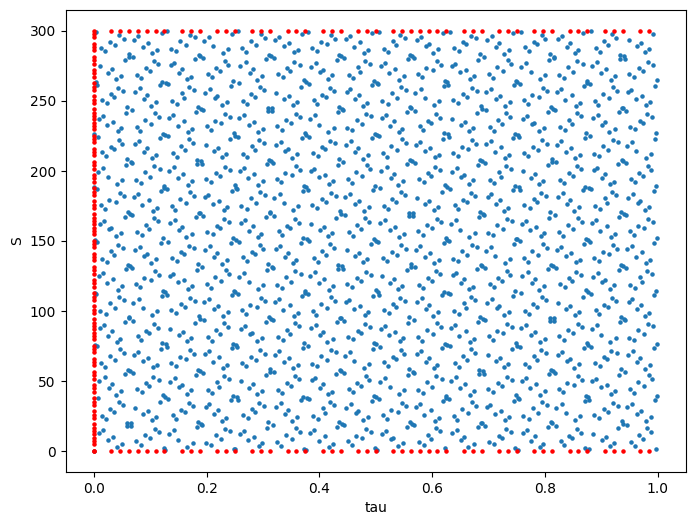

In [232]:
from PINN.utilities import collocation_points

SCALE = K / 10
N_pde = 2000
np.random.seed(128)
nn = kan.KAN([2,2,1]) if EFFICIENT_KAN else \
     kan.KAN(width=[2,2,1], grid=5, k=3, device=device)
model = VanillaOptionPINN(nn, K, T, sigma, r,
                          S_inf, scale=SCALE,
                          type=TYPE, style=STYLE,
                          device=device).to(device)
# print(model)

# sample collocation points
sobol = torch.quasirandom.SobolEngine(dimension=2)
tau_pde, S_pde = collocation_points(model, N_pde, sampling='sobol', sobol=sobol)

# plot
plt.figure(figsize=(8, 6))
plt.scatter(tau_pde.detach().numpy(), S_pde.detach().numpy(), s=5, label='Interior')
plt.scatter(tau_ib.detach().numpy(), S_ib.detach().numpy(), s=5, c='red', label='Boundary')
plt.xlabel('tau')
plt.ylabel('S')
plt.show()

In [233]:
optimal_width = None
optimal_grid = None
optimal_params = None
min_eval_rmse = float('inf')
eval_mpe = 0.

In [241]:
WIDTH = [2, 4, 4, 1]
GRID0 = 16
BASE_ACTIVATION = torch.nn.Tanh
np.random.seed()
if EFFICIENT_KAN:
    nn = kan.KAN(WIDTH, grid_size=GRID0, spline_order=3,
                 grid_range=[0, 100],  # [-1, 1]
                 base_activation=BASE_ACTIVATION)
else:
    # grid_eps=0. for adaptive grid based on sample distribution
    # grid_eps=1 for uniform grid
    nn = kan.KAN(width=WIDTH, grid=GRID0, k=3, grid_eps=0.)
print(nn)
print('Number of parameters:', sum(p.numel() for p in nn.parameters()))

KAN(
  (layers): ModuleList(
    (0-2): 3 x KANLinear(
      (base_activation): Tanh()
    )
  )
)
Number of parameters: 588


In [242]:
REFINE = False and not EFFICIENT_KAN  # for original KAN only
EPOCHS_LBFGS = 500
EPOCHS_ADAM = 500
LR_ADAM = 1e-2
EARLY_STOPPING = 50
SPEED = True
log = 1
# PINN parameters
SCALE = K / 10
N_pde = 2000
# ---
if REFINE:
    grids = [100]
else:
    grids = [GRID0]
    loss_history = {'ib': [], 'pde': [], 'total': []}


for grid in grids:
    print(model.V_nn)
    if not REFINE:
        nn = nn.speed() if SPEED and not EFFICIENT_KAN else nn
        model = VanillaOptionPINN(nn, K, T, sigma, r,
                                  S_inf, scale=SCALE,
                                  type=TYPE, style=STYLE,
                                  device=device).to(device)
        print('Number of parameters:', sum(p.numel() for p in model.parameters()))
    else:
        model.V_nn.save_act = True
        model.V_nn.get_act(torch.cat((tau_pde, S_pde), dim=1))
        model.V_nn = model.V_nn.refine(grid)
        model.V_nn = model.V_nn.speed() if SPEED else model.V_nn

    def train(epochs, optimizer='lbfgs', lr=1e-3):
        optimzer = optimizer.lower()
        if optimzer == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        elif optimzer == 'lbfgs':
            if EFFICIENT_KAN:
                optimizer = torch.optim.LBFGS(model.parameters(),
                                              lr=1., max_iter=20, history_size=100,
                                              line_search_fn="strong_wolfe")
            else:
                optimizer = kan.LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe",
                                      tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
        pbar = tqdm(range(epochs), desc='description', ncols=100)
        patience = 0
        min_loss = float('inf')
        for _ in pbar:
            def closure():
                global loss_ib, loss_pde
                optimizer.zero_grad()
                loss_ib, loss_pde, loss_data = model.loss(tau_ib, S_ib, V_ib,
                                                 tau_pde, S_pde)
                loss = loss_ib + loss_pde
                loss.backward(retain_graph=True)
                return loss

            # for original KAN
            if not EFFICIENT_KAN and _ % 5 == 0 and _ < 20:
                model.V_nn.update_grid_from_samples(torch.cat((tau_pde, S_pde), dim=1))

            loss = optimizer.step(closure).cpu().detach().numpy()
            if np.isnan(loss):
                print(f'NaN loss detected at epoch {_ + 1}')
                return
            if loss >= min_loss or np.isclose(loss, min_loss, rtol=1e-5, atol=1e-8):
                patience += 1
                if patience >= EARLY_STOPPING:
                    print(f'Early stopping at epoch {_ + 1}')
                    break
            else:
                min_loss, patience = loss, 0

            if _ % log == 0:
                pbar.set_description("pde loss: %.2e | ib loss: %.2e | total: %.2e " % (loss_pde.cpu().detach().numpy(), loss_ib.cpu().detach().numpy(), loss))

            loss_history['ib'].append(loss_ib.cpu().detach().numpy())
            loss_history['pde'].append(loss_pde.cpu().detach().numpy())
            loss_history['total'].append(loss)

    train(EPOCHS_ADAM, optimizer='adam', lr=LR_ADAM) if EFFICIENT_KAN else None
    train(EPOCHS_LBFGS, optimizer='lbfgs')

KAN(
  (layers): ModuleList(
    (0-3): 4 x KANLinear(
      (base_activation): Tanh()
    )
  )
)
Number of parameters: 588


pde loss: 5.00e-03 | ib loss: 1.17e-02 | total: 1.67e-02 : 100%|██| 500/500 [00:29<00:00, 16.80it/s]
pde loss: 6.88e-05 | ib loss: 1.02e-04 | total: 1.70e-04 :  67%|█▎| 337/500 [06:00<02:54,  1.07s/it]

Early stopping at epoch 338


In [246]:
SAVE_FIG = True
KAN_NAME = 'KAN' + str(WIDTH[1:-1]).replace(' ', '').replace('[', '(').replace(']', ')') + f'_grid{grid}'
print(KAN_NAME)

KAN(4,4)_grid16


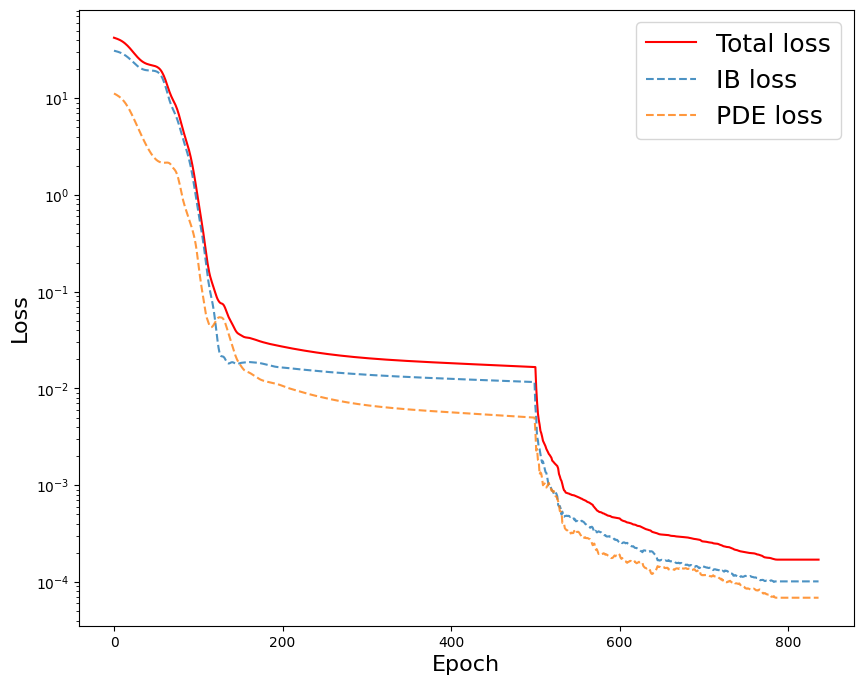

In [247]:
# plot loss history
plt.figure(figsize=(10, 8))
plt.plot(loss_history['total'], label='Total loss', c='red')
plt.plot(loss_history['ib'], label='IB loss', ls='--', alpha=0.8)
plt.plot(loss_history['pde'], label='PDE loss', ls='--', alpha=0.8)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.yscale('log')
plt.legend(fontsize=18)
if SAVE_FIG:
    plt.savefig(f'./data/figures/loss_{STYLE}_{TYPE}_{KAN_NAME}.pdf', bbox_inches='tight')
plt.show()

Current width: [2, 4, 4, 1]
Current grid: 16
Current num of parameters: 588
Optimal width: [2, 8, 4, 2, 1]
Optimal grid: 16
Min RMSE: 0.034982566144694464
with MPE: 0.410523536327009
Current MPE 0.6405738789040063
MPE at: 0.0 99.0990990990991


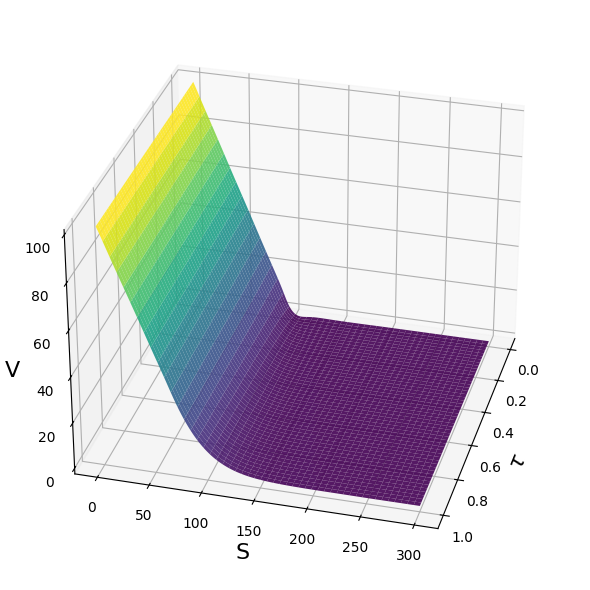

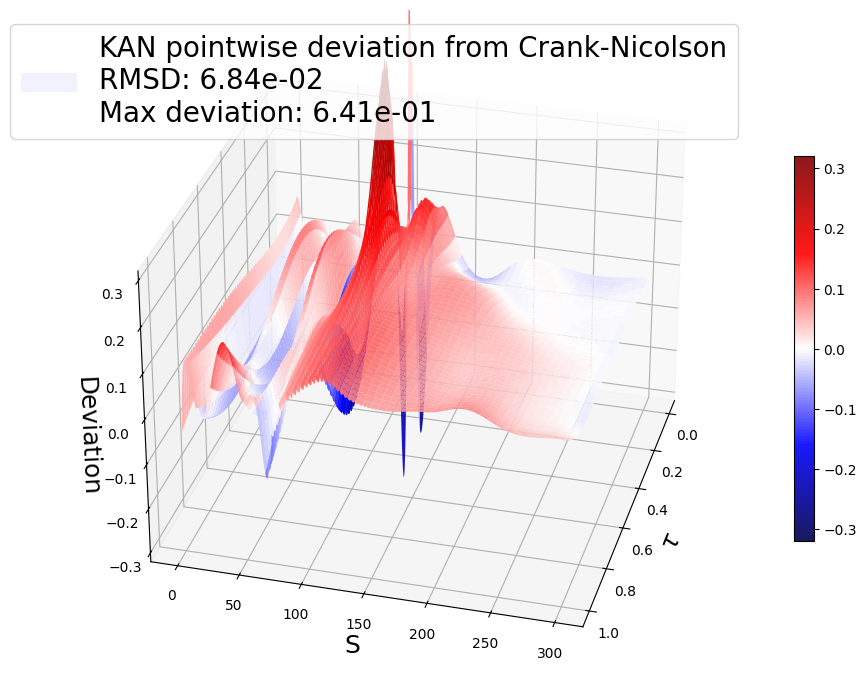

In [250]:
from scipy.interpolate import RegularGridInterpolator

S_eval = torch.linspace(0, S_inf, 1000)
tau_eval = torch.linspace(0, T, 1000)
S_eval, tau_eval = torch.meshgrid(S_eval, tau_eval, indexing='xy')
if not EFFICIENT_KAN:
    model.V_nn.save_act = True
V_pred = model(tau_eval.reshape(-1, 1), S_eval.reshape(-1, 1)).detach().numpy().reshape(1000, 1000)
model.V_nn.plot() if not EFFICIENT_KAN else None
print('Current width:', WIDTH)
print('Current grid:',grid)
print('Current num of parameters:', sum(p.numel() for p in model.parameters()))

S_eval, tau_eval = np.meshgrid(np.linspace(0, S_inf, 1000), np.linspace(0, T, 1000))
V_CN, t_CN, S_CN = V_BS_CN(100, 100, K, T, sigma, r, S_inf, TYPE, STYLE)
interpolator = RegularGridInterpolator((t_CN, S_CN), V_CN, method='linear', bounds_error=False, fill_value=np.nan)
V_ref = interpolator((tau_eval, S_eval))
V_true = V_ref
V_err = V_pred - V_true
mse = np.mean(V_err**2)
rmse = np.sqrt(mse)
mpe = np.max(np.abs(V_err))
if rmse < min_eval_rmse:
    min_eval_rmse = rmse
    eval_mpe = mpe
    optimal_width = WIDTH
    optimal_grid = grid
    optimal_params = sum(p.numel() for p in model.parameters())
print('Optimal width:', optimal_width)
print('Optimal grid:', optimal_grid)
print('Min RMSE:', min_eval_rmse)
print('with MPE:', eval_mpe)
print('Current MPE', mpe)
idx = np.unravel_index(np.argmax(np.abs(V_err)), V_err.shape)
print('MPE at:', tau_eval[idx], S_eval[idx])

# 3d plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, V_pred,
                       cmap='viridis', alpha=0.9)
ax.set_xlabel(r'$\tau$', fontsize=16)
ax.set_ylabel('S', fontsize=16)
ax.set_zlabel('V', fontsize=16)
ax.view_init(elev=30, azim=15)
plt.tight_layout()
plt.show()

# plot error surface
scale = mpe/2
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, V_err,
                       label=f'KAN pointwise deviation from Crank-Nicolson\nRMSD: {rmse:.2e}\nMax deviation: {mpe:.2e}',
                       cmap='seismic', vmin=-scale, vmax=scale, alpha=0.9)
cbar = fig.colorbar(surf, location='right', shrink=0.5)
ax.set_zlim(-scale, scale)
ax.set_xlabel(r'$\tau$', fontsize=18)
ax.set_ylabel('S', fontsize=18)
ax.set_zlabel('Deviation', fontsize=18)
# ax.set_zscale('symlog')
plt.legend(fontsize=20, loc='upper right')
ax.view_init(elev=30, azim=15)
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(f'./data/figures/err_{STYLE}_{TYPE}_{KAN_NAME}.pdf', bbox_inches='tight')
plt.show()